In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import tarfile 
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from math import log2

2022-12-05 03:36:08.876440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Extract and Load Data

In [5]:
def extract_data(tarfile_path = './dataset.tar'):
  with tarfile.TarFile(tarfile_path) as f:
    f.extractall()

extract_data()

In [17]:
batch_size = 128

train_ds = keras.utils.image_dataset_from_directory(
    './Dataset/train',
    label_mode='int',
    batch_size=batch_size,
    image_size=(224, 224),
)

val_ds = keras.utils.image_dataset_from_directory(
    './Dataset/val',
    label_mode='int',
    batch_size=batch_size,
    image_size=(224, 224),
    shuffle = False
)

Found 100000 files belonging to 1000 classes.
Found 50000 files belonging to 1000 classes.


# Create model

## Get Feature Extractor

In [19]:
mobile_net_feature_extractor = keras.applications.mobilenet_v2.MobileNetV2(
    alpha=1,
    include_top=False, 
    weights='imagenet', 
    input_shape = (224,224,3), 
    pooling='avg'
    )
for layer in mobile_net_feature_extractor.layers:
    layer.trainable = False

In [20]:
mobile_net_feature_extractor.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

## Helper Functions to create models

In [14]:
def create_baseline_model(feature_extractor, classes = 1000, image_size = 224):
    inp = keras.Input(shape = (image_size, image_size,3))
    x = keras.applications.mobilenet_v2.preprocess_input(inp)
    x = feature_extractor(x)
    out = keras.layers.Dense(classes, activation = 'softmax')(x)

    return keras.models.Model(inputs=[inp], outputs= [out])

def create_mec_model(feature_extractor, classes = 1000, image_size = 224):
    '''1280 * 32 + 32'''
    inp = keras.Input(shape = (image_size, image_size,3))
    x = keras.applications.mobilenet_v2.preprocess_input(inp)
    x = feature_extractor(x)
    x = keras.layers.Dense(32, activation = 'relu')(x)
    out = keras.layers.Dense(classes, activation = 'softmax')(x)
    return keras.models.Model(inputs=[inp], outputs= [out]) 

def create_information_capacity_model(feature_extractor, classes = 1000, image_size = 224):
    '''1280 * 77 + 77'''
    inp = keras.Input(shape = (image_size, image_size,3))
    x = keras.applications.mobilenet_v2.preprocess_input(inp)
    x = feature_extractor(x)
    x = keras.layers.Dense(77, activation = 'relu')(x)
    out = keras.layers.Dense(classes, activation = 'softmax')(x)
    return keras.models.Model(inputs=[inp], outputs= [out]) 

def increased_compression_model(feature_extractor, classes = 1000, image_size = 224):
    feature_extractor = keras.models.Model(feature_extractor.input, feature_extractor.layers[-5].output)
    
    inp = keras.Input(shape = (image_size, image_size,3))
    x = keras.applications.mobilenet_v2.preprocess_input(inp)
    x = feature_extractor(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    out = keras.layers.Dense(classes, activation = 'softmax')(x)
    return keras.models.Model(inputs=[inp], outputs= [out]) 

model = increased_compression_model(mobile_net_feature_extractor)
model.summary()
    
    

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 model_5 (Functional)        (None, 7, 7, 320)         1843264   
                                                                 
 global_average_pooling2d_6   (None, 320)              0         
 (GlobalAveragePooling2D)                                        
                                                           

# Training

In [22]:
model_name = 'baseline_overfit'
os.mkdir(model_name)
epochs = 1000
overfit = True

In [23]:
model = create_baseline_model(mobile_net_feature_extractor)
# model = create_mec_model(mobile_net_feature_extractor)
# model = create_information_capacity_model(mobile_net_feature_extractor)

In [26]:
if overfit:
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience= 10, verbose = 1),
        tf.keras.callbacks.ModelCheckpoint(filepath = f'./{model_name}/{model_name}.h5', monitor = 'loss', save_best_only = True, verbose = 1),
        tf.keras.callbacks.LearningRateScheduler(keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.045, decay_steps=1, decay_rate=0.98))
        ]
else:
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10, verbose = 1),
        tf.keras.callbacks.ModelCheckpoint(filepath = f'./{model_name}/{model_name}.h5', monitor = 'val_loss', save_best_only = True, verbose = 1),
        tf.keras.callbacks.LearningRateScheduler(keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.045, decay_steps=1, decay_rate=0.98))
        ]

In [27]:
model.compile(
      optimizer= keras.optimizers.RMSprop(
          learning_rate = 0.045,
          momentum=0.9,
          rho = 0.9
          ),
      loss = keras.losses.SparseCategoricalCrossentropy(), 
      metrics=['accuracy']
      )

history = model.fit(
    train_ds,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = val_ds
    )

Epoch 1/1000
781/782 [============================>.] - ETA: 0s - loss: 109.8463 - accuracy: 0.6168
Epoch 1: loss improved from inf to 109.83484, saving model to ./baseline_overfit/baseline_overfit.h5
782/782 [==============================] - 50s 61ms/step - loss: 109.8348 - accuracy: 0.6169 - val_loss: 187.5209 - val_accuracy: 0.5469 - lr: 0.0450
Epoch 2/1000
781/782 [============================>.] - ETA: 0s - loss: 74.3713 - accuracy: 0.7304
Epoch 2: loss improved from 109.83484 to 74.37264, saving model to ./baseline_overfit/baseline_overfit.h5
782/782 [==============================] - 47s 60ms/step - loss: 74.3726 - accuracy: 0.7304 - val_loss: 200.7561 - val_accuracy: 0.5636 - lr: 0.0441
Epoch 3/1000
781/782 [============================>.] - ETA: 0s - loss: 52.7193 - accuracy: 0.7895
Epoch 3: loss improved from 74.37264 to 52.71735, saving model to ./baseline_overfit/baseline_overfit.h5
782/782 [==============================] - 47s 60ms/step - loss: 52.7174 - accuracy: 0.7895

KeyboardInterrupt: 

## Train plots

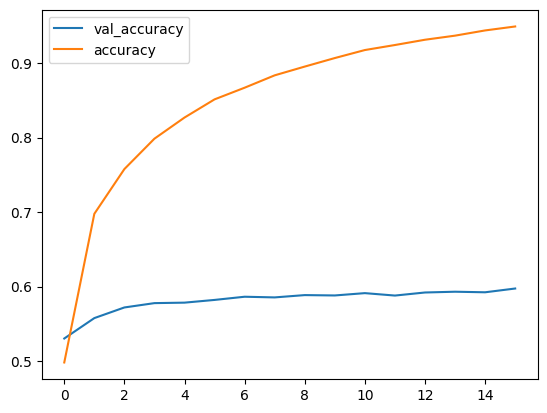

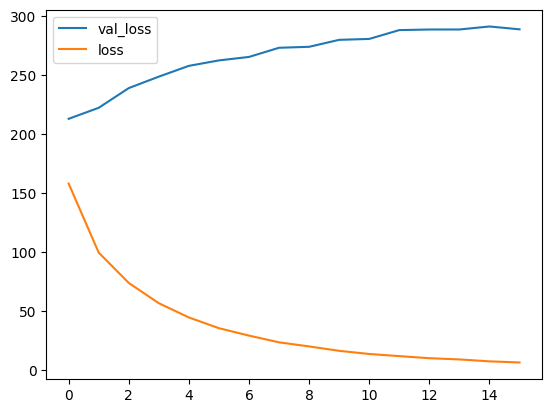

In [ ]:
pd.DataFrame(history.history).to_csv(f'./{model_name}/{model_name}.csv', index = False)

df = pd.read_csv(f'./{model_name}/{model_name}.csv')

df[['val_accuracy', 'accuracy']].plot()
df[['val_loss', 'loss']].plot()


# Test result

In [ ]:
import numpy as np

def get_predictions_and_labels(model_path, data):
    model = keras.models.load_model(model_path)
    predictions = model.predict(data)
    labels = []
    for _, y in data.as_numpy_iterator():
        labels.extend(y)
        
    return predictions, labels

782/782 [==============================] - 828s 1s/step


In [ ]:
predictions, labels = get_predictions_and_labels(f'./{model_name}/{model_name}.h5', val_ds)

In [ ]:
from sklearn.metrics import top_k_accuracy_score
print('Top 1 accuracy:', top_k_accuracy_score(labels, predictions, k = 1))
print('Top 5 accuracy:', top_k_accuracy_score(labels, predictions, k = 5))

53.01706034120682

In [ ]:
def generalization_ratio(labels, predictions, MEC):
    class_count = Counter(labels)
    correct_prediction_count = {i:0 for i in range(1000)}

    for p, gt in zip(predictions, labels):
        if np.argmax(p) == gt:
            correct_prediction_count[gt] += 1

    return -sum(correct_prediction_count[key] * log2(class_count[key] / len(labels)) for key in class_count)/MEC

In [ ]:
print('Generalization ratio:', generalization_ratio(labels, predictions, 1.28e6))

0.20638554550299582